# Adaptive Deep Q-Networks for Decision Making in Non-Stationary Environments: A Case Study with the Wisconsin Card Sorting Test

**WCST notebook credits:**

__RL Environment & Training loop:__ Dieu-Donné Fangnon, Eduardo Ramirez

__WCST original implementation:__ Pauline Bock


---
# Setup

In [1]:
# @title Install dependencies
!pip install jedi --quiet
!pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet
!pip install numpy==1.23.3 --quiet --ignore-installed
!pip uninstall seaborn -y --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━

In [2]:
# Imports
import time
import numpy as np
import pandas as pd
import sonnet as snt
import seaborn as sns
import matplotlib.pyplot as plt

import dm_env

import acme
from acme import specs
from acme import wrappers
from acme import EnvironmentLoop
from acme.agents.tf import dqn
from acme.utils import loggers
import scipy.stats as stats

/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(version) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
import torch
torch.cuda.empty_cache()
from fastai.vision.all import *

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False

In [5]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

## Datasets

This notebook works on simulated data only.

## Wisconsin Card Sorting task (WCST)

---
# Cognitive Tests Environment


## Implementation scheme


## Random agent

In [6]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

### WCST utility methods

From [Pauline Bock's repository](https://github.com/PaulineBock/WCSTDehaeneChangeux)

In [7]:
from tensorflow import float32
"""
Module WCST (Imported as regular functions)

Generates cards for the different WCST tasks.

Pauline Bock
09-04-2019
"""
import numpy as np
import random
import sys

def perception(nb_dim, nb_templates, nb_features):
    """
    Create and return reference cards.
    """
    percep_shape = (nb_templates, nb_dim, nb_features)
    percep = np.zeros(percep_shape, dtype=float)

    #Random generating of binary features
    for i in range(0, nb_templates):
        for j in range(0, nb_dim):
            percep[i][j].put([i], 1)

    return percep

def response_item_Reasoning(nb_dim, nb_features, m_percep, reasoning_list):
    """
    Create and return a card for Reasoning version that was not already created. (36 ambiguous cards).
    """
    item = create_card_Reasoning(nb_dim, nb_features)
    #check if different from reference cards
    eq = check_equality(m_percep, item, nb_dim)
    unique = check_unity(item, reasoning_list)

    while(eq == 1 or unique==1):
        item = create_card_Reasoning(nb_dim, nb_features)
        eq = check_equality(m_percep, item, nb_dim)
        unique = check_unity(item, reasoning_list)

    reasoning_list.append(item)
    return item

def check_unity(item, cardlist):
    if inList(item, cardlist) == True:
        return 1
    else:
        return 0

def create_card_Reasoning(nb_dim, nb_features):
    """
    Create a card with ambiguity.
    """
    item_shape = (nb_dim, nb_features)
    item = np.zeros(item_shape, dtype=float)

    r = [0,1,2]
    #random 2 different dimensions
    idim1 = random.randint(0,2)
    dim1 = r[idim1]
    r.remove(dim1)
    idim2 = random.randint(0,len(r)-1)
    dim2 = r[idim2]
    r.remove(dim2)
    dim3 = r[0]

    feat = random.randint(0,3)
    feat2 = random.randint(0,3)
    while(feat == feat2):
        feat2 = random.randint(0,3)

    np.put(item[dim1],[feat], 1)
    np.put(item[dim2],[feat], 1)
    np.put(item[dim3],[feat2], 1)

    return item


def check_equality(m_percep, item, nb_dim):
    """
    Check if the card is different from the reference ones.
    """
    for temp in range(0, m_percep.shape[0]):
        dim_eq = 0
        for dim in range(0, nb_dim):
            if np.array_equal(m_percep[temp][dim], item[dim]):
                dim_eq +=1

        if dim_eq == nb_dim:
            return 1

    return 0

def inList(array, arraylist):
    for element in arraylist:
        if np.array_equal(element, array):
            return True
    return False


### Environment

The following cell implments an envinronment and the training loop for each agent:
- Rewards the agent once the action was correct (i.e., a normative model of the environment).

In [8]:
from acme import specs as acme_specs

## RANDOM

Here we implement the environment for the random agent without integrate the rule context into the state space.

In [ ]:
class WCSTR_Env(dm_env.Environment):
    ACTIONS = [0, 1, 2, 3]

    def __init__(self,seed=1):

        self.episode_steps = 36  #36 cards or steps per episode

        #Init WCST variables
        self.nb_dim = 3
        self.nb_features = 4
        self.nb_templates = self.nb_features
        r = 3  #rules number, we have 3 rules
        self.m_percep = perception(self.nb_dim, self.nb_templates, self.nb_features)

        self._reset_next_step = True
        self._current_step = 0  #Current episode step counter
        self._action_history = []
        self.nbTS = 0
        self.nb_win = 0
        self.t_criterion = 0
        self.t_err = 0
        self.criterions = []
        self.winstreak = 0
        self.seen_cards = []
        self.rule = 0
        self.np_data = []
        self.v_data = []
        self.last_successful_action = None
        self.random_change_prob = 0.1  # Probability of rule change at any given step




    def new_card(self):
        v_data = [] #list type
        np_data = response_item_Reasoning(self.nb_dim, self.nb_features, self.m_percep, self.seen_cards) #Modified WCST version

        #Transform into a vector
        for arr in np_data:
            for e in arr:
                v_data.append(e)

        #Save last card info
        self.np_data = np_data
        self.v_data = v_data

        return np_data, v_data

    def reset(self):
        self._reset_next_step = False

        self._current_step = 0  #Current episode step counter
        self.nbTS = 0
        self.nb_win = 0
        self.t_criterion = 0
        self.t_err = 0
        self.criterions = []
        self.winstreak = 0
        self.seen_cards = []
        self.np_data = []
        self.v_data = []

        self._action_history.clear()

        if self.last_successful_action is not None:
            # Repeat the last successful action
            return dm_env.transition(reward=0.0, observation=self._observation())
        else:
            # Choose a random action if no successful action has been recorded
            return dm_env.transition(reward=0.0, observation=self._observation())

        #Deal new card
        return dm_env.restart(self._observation())

    def _episode_return(self):
      return 0.0


    def rule_switching(self, current_rule):
        """Switches the rule to a new one randomly."""
        new_rule = np.random.choice([r for r in range(3) if r != current_rule])
        # print(f"Switching rule from {current_rule} to {new_rule}.")
        return new_rule


    def external_feedback(self, action):
        """
        Returns a true reward according to the success or not of the card chosen.
        """
        response_card = self.np_data
        reference_cards = self.m_percep
        right_action_i = 0

        for i in range(0, self.nb_templates):

            if np.array_equal(reference_cards[i][self.rule], response_card[self.rule]):
                right_action_i = i

        if right_action_i == action:

            return 1.
        else:

            return -1.

    def step(self, action: int):

        if self._reset_next_step:
            return self.reset()

        if np.random.rand() < self.random_change_prob:
            self.rule = self.rule_switching(self.rule)
            self.rule_changed = True
            self.rule_change_points.append(self._current_step)
            self.nbTS +=1

        agent_action = WCSTR_Env.ACTIONS[action]

        #Compute reward
        step_reward = self.external_feedback(agent_action)

        ##Winstreak count
        if step_reward == 1.:
            self.t_err = 0
            self.nb_win += 1
            self.winstreak += 1
            self.last_successful_action = agent_action

        if step_reward == -1.:
            self.t_criterion += 1
            self.t_err += 1
            self.winstreak = 0


        self._action_history.append(agent_action)
        self._current_step += 1

        # Check for termination.
        if self.nbTS >= 6 or self._current_step == (self.episode_steps - 1):
            self._reset_next_step = True

            return dm_env.termination(reward=self._episode_return(), observation=self._observation())
        else:
            #Send reward to agent and a new observation
            return dm_env.transition(reward=step_reward, observation=self._observation())



    def observation_spec(self):
        return dm_env.specs.Array(
            shape=(3, 4),
            dtype=np.float32,
            name='card'
        )




    def action_spec(self):
        return dm_env.specs.DiscreteArray(
            num_values=len(WCSTR_Env.ACTIONS),
            dtype=np.int32,
            name='action')
        pass


    def _observation(self):
        np_data, card = self.new_card()

        obs = self.np_data[:self._current_step+1].copy()
        obs = np.pad(obs,(0, len(self.np_data) - len(obs)))

        return obs


    @staticmethod
    def create_environment():
        """Utility function to create a N-back environment and its spec."""

        environment = wrappers.SinglePrecisionWrapper(WCSTR_Env())

        # Grab the spec of the environment.
        environment_spec = specs.make_environment_spec(environment)
        return environment, environment_spec

In [ ]:
random_seed(2022)

env, env_spec = WCSTR_Env.create_environment()

agent = RandomAgent(env_spec)

# Training parameters
n_episodes = 1000
episode_rewards_r = []
episode_errors_r = []
episode_wins_r = []
episode_accuracies_r = []


# Main training loop
for episode in range(n_episodes):
    episode_return_r = 0
    episode_error_count_r = 0
    episode_win_count_r = 0
    timestep = env.reset()

    start_time = time.time()

    timestep = env.reset()

  # Run an episode
    while not timestep.last():

    # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = env.step(action)

    # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()



      timestep = timestep

      episode_return_r += timestep.reward

      if timestep.reward == -1.:
          episode_error_count_r += 1
      elif timestep.reward == 1.:
          episode_win_count_r += 1



    # Append the episode's return to the list after the episode concludes
    episode_rewards_r.append(episode_return_r)
    episode_errors_r.append(episode_error_count_r)
    episode_wins_r.append(episode_win_count_r)

    # Calculate accuracy for the episode
    episode_accuracy_r = (episode_win_count_r / (episode_win_count_r + episode_error_count_r)) * 100
    episode_accuracies_r.append(episode_accuracy_r)


# Calculate and print overall metrics
total_accuracy_r = np.mean(episode_accuracies_r)
total_error_rate_r = (sum(episode_errors_r) / (sum(episode_wins_r) + sum(episode_errors_r))) * 100

print("Training completed.")
print(f'Overall Accuracy: {total_accuracy_r:.2f}%')
print(f'Total Errors: {sum(episode_errors_r)}')
print(f'Total Wins: {sum(episode_wins_r)}')
print(f'Error Rate: {total_error_rate_r:.2f}%')

Training completed.
Overall Accuracy: 25.34%
Total Errors: 24880
Total Wins: 8422
Error Rate: 74.71%


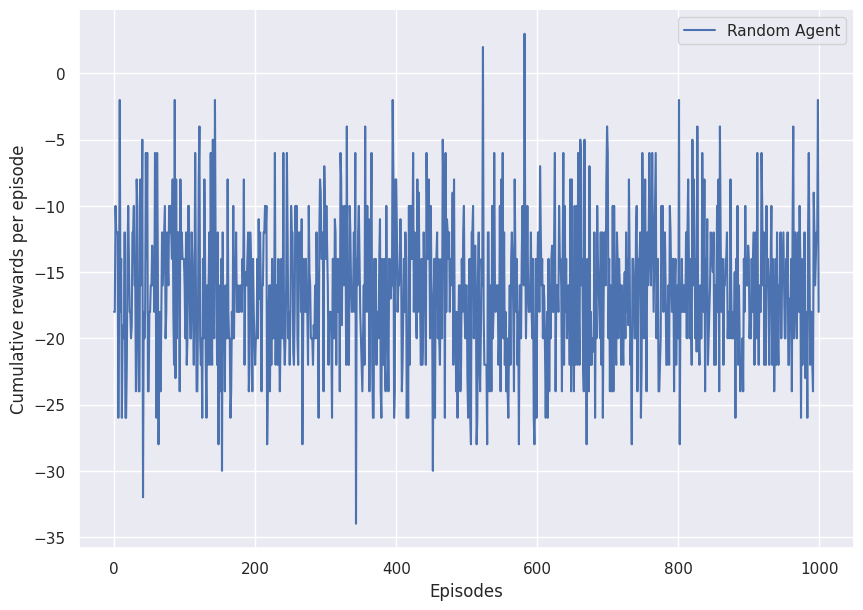

In [ ]:
# Plotting the rewards over episodes
plt.figure(figsize=(10, 7))
plt.plot(episode_rewards_r, label='Random Agent')
plt.xlabel('Episodes')
plt.ylabel('Cumulative rewards per episode')
plt.grid(True)
plt.legend()
plt.show()

## END RANDOM

## The baseline/initial DQN agent

Here we also implement the environment for the baseline DQN agent without integrate the rule context into the state space.

In [ ]:
class WCST_Env(dm_env.Environment):
    ACTIONS = [0, 1, 2, 3]

    def __init__(self,seed=1):

        self.episode_steps = 36  #36 cards or steps per episode

        #Init WCST variables
        self.nb_dim = 3
        self.nb_features = 4
        self.nb_templates = self.nb_features
        r = 3  #rules number, we have 3 rules
        self.m_percep = perception(self.nb_dim, self.nb_templates, self.nb_features)

        self._reset_next_step = True
        self._current_step = 0
        self._action_history = []
        self.nbTS = 0
        self.nb_win = 0
        self.t_criterion = 0
        self.t_err = 0
        self.criterions = []
        self.winstreak = 0
        self.seen_cards = []
        self.rule = 0
        self.np_data = []
        self.v_data = []
        self.last_successful_action = None
        self.rule_changed = False
        self.rule_change_points = []
        self.random_change_prob = 0.1  # Probability of rule change at any given step




    def new_card(self):
        v_data = [] #list type
        np_data = response_item_Reasoning(self.nb_dim, self.nb_features, self.m_percep, self.seen_cards) #Modified WCST version

        #Transform into a vector
        for arr in np_data:
            for e in arr:
                v_data.append(e)

        #Save last card info
        self.np_data = np_data
        self.v_data = v_data

        return np_data, v_data

    def reset(self):
        self._reset_next_step = False

        self._current_step = 0  #Current episode step counter
        self.nbTS = 0
        self.nb_win = 0
        self.t_criterion = 0
        self.t_err = 0
        self.criterions = []
        self.winstreak = 0
        self.seen_cards = []
        self.np_data = []
        self.v_data = []

        self._action_history.clear()

        if self.last_successful_action is not None:
            # Repeat the last successful action
            return dm_env.transition(reward=0.0, observation=self._observation())
        else:
            # Choose a random action if no successful action has been recorded
            return dm_env.transition(reward=0.0, observation=self._observation())

        #Deal new card
        return dm_env.restart(self._observation())

    def _episode_return(self):
      return 0.0


    def rule_switching(self, current_rule):
        """Switches the rule to a new one randomly."""
        new_rule = np.random.choice([r for r in range(3) if r != current_rule])
        # print(f"Switching rule from {current_rule} to {new_rule}.")
        return new_rule


    def external_feedback(self, action):
        """
        Returns a true reward according to the success or not of the card chosen.
        """
        response_card = self.np_data
        reference_cards = self.m_percep
        right_action_i = 0

        for i in range(0, self.nb_templates):

            if np.array_equal(reference_cards[i][self.rule], response_card[self.rule]):
                right_action_i = i

        if right_action_i == action:

            return 1.
        else:

            return -1.

    def step(self, action: int):

        if self._reset_next_step:
            return self.reset()

        if np.random.rand() < self.random_change_prob:
            self.rule = self.rule_switching(self.rule)
            self.rule_changed = True
            self.rule_change_points.append(self._current_step)
            self.nbTS +=1

        agent_action = WCST_Env.ACTIONS[action]

        #Compute reward
        step_reward = self.external_feedback(agent_action)

        ##Winstreak count
        if step_reward == 1.:
            self.t_err = 0
            self.nb_win += 1
            self.winstreak += 1
            self.last_successful_action = agent_action

        if step_reward == -1.:
            self.t_criterion += 1
            self.t_err += 1
            self.winstreak = 0


        self._action_history.append(agent_action)
        self._current_step += 1

        # Check for termination.
        if self.nbTS >= 6 or self._current_step == (self.episode_steps - 1):
            self._reset_next_step = True

            return dm_env.termination(reward=self._episode_return(), observation=self._observation())
        else:
            #Send reward to agent and a new observation
            return dm_env.transition(reward=step_reward, observation=self._observation())



    def observation_spec(self):
        return dm_env.specs.Array(
            shape=(3, 4),
            # shape=(self.nb_features * self.nb_dim + 1,),
            dtype=np.float32,
            name='card'
        )


    def action_spec(self):
        return dm_env.specs.DiscreteArray(
            num_values=len(WCST_Env.ACTIONS),
            dtype=np.int32,
            name='action')
        pass


    def _observation(self):
        np_data, card = self.new_card()

        obs = self.np_data[:self._current_step+1].copy()
        obs = np.pad(obs,(0, len(self.np_data) - len(obs)))
        obs = np_data

        return obs


    @staticmethod
    def create_environment():
        """Utility function to create a N-back environment and its spec."""

        environment = wrappers.SinglePrecisionWrapper(WCST_Env())

        # Grab the spec of the environment.
        environment_spec = specs.make_environment_spec(environment)
        return environment, environment_spec

In [ ]:
def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
    return snt.Sequential([
        snt.Flatten(),
        snt.nets.MLP([500, 500, action_spec.num_values]),
    ])


# Initialize the environment and the DQN agent
env, env_spec = WCST_Env.create_environment()



agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.00001],  # Epsilon for exploration
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)


# Training parameters
n_episodes_dqn = 1000
episode_rewards = []
episode_errors = []
episode_wins = []
episode_accuracies = []


# Main training loop
for episode in range(n_episodes_dqn):
    episode_return = 0
    episode_error_count = 0
    episode_win_count = 0
    timestep = env.reset()

    agent.observe_first(timestep._replace(step_type=np.array(0, dtype=np.int32)))


    while not timestep.last():
        action = agent.select_action(timestep.observation)
        next_timestep = env.step(action)


        # React to rule change
        # if env.rule_changed:
        #     print("Rule change detected. Adjusting agent...")
        #     agent.observe_first(timestep._replace(step_type=np.array(0, dtype=np.int32)))


        agent.observe(action, next_timestep=next_timestep)
        agent.update()

        timestep = next_timestep

        episode_return += timestep.reward
        if timestep.reward == -1.:
            episode_error_count += 1
        elif timestep.reward == 1.:
            episode_win_count += 1



    # Append the episode's return to the list after the episode concludes
    episode_rewards.append(episode_return)
    episode_errors.append(episode_error_count)
    episode_wins.append(episode_win_count)

    # Calculate accuracy for the episode
    episode_accuracy = (episode_win_count / (episode_win_count + episode_error_count)) * 100
    episode_accuracies.append(episode_accuracy)


# Calculate and print overall metrics
total_accuracy = np.mean(episode_accuracies)
total_error_rate = (sum(episode_errors) / (sum(episode_wins) + sum(episode_errors))) * 100

print("Training completed.")
print(f'Overall Accuracy: {total_accuracy:.2f}%')
print(f'Total Errors: {sum(episode_errors)}')
print(f'Total Wins: {sum(episode_wins)}')
print(f'Error Rate: {total_error_rate:.2f}%')

Training completed.
Overall Accuracy: 58.73%
Total Errors: 13651
Total Wins: 19409
Error Rate: 41.29%


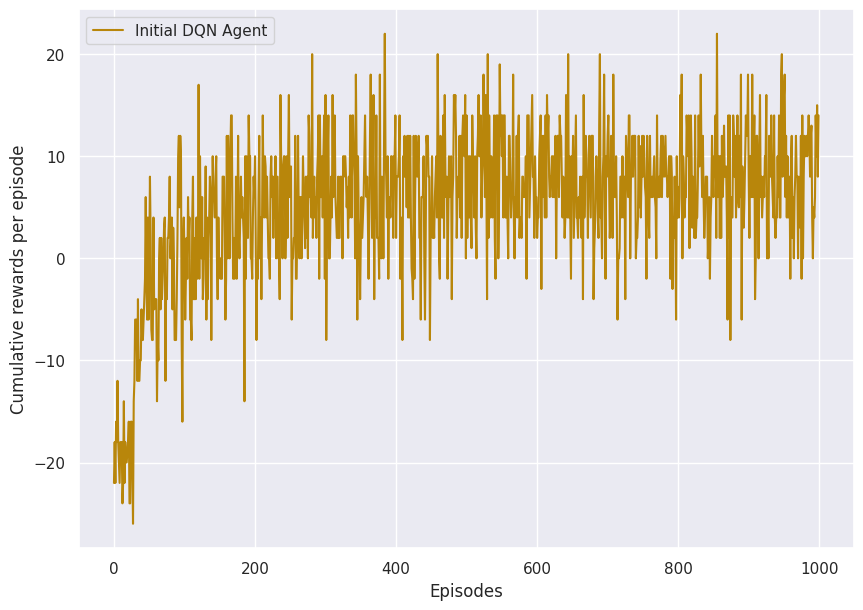

In [ ]:
# Plotting the rewards over episodes
plt.figure(figsize=(10, 7))
plt.plot(episode_rewards, label='Initial DQN Agent', color = 'darkgoldenrod')
plt.xlabel('Episodes')
plt.ylabel('Cumulative rewards per episode')

plt.grid(True)
plt.legend()
plt.show()

END

## WCST NS-DQN agent (Our modified agent)

Here now we implement the modified environment where we integrate the rule context into the state space.

In [ ]:
class WCSTns_Env(dm_env.Environment):
    ACTIONS = [0, 1, 2, 3]

    def __init__(self,seed=1):

        self.episode_steps = 36  #36 cards or steps per episode

        #Init WCST variables
        self.nb_dim = 3
        self.nb_features = 4
        self.nb_templates = self.nb_features
        r = 3  #rules number, we have 3 rules
        self.m_percep = perception(self.nb_dim, self.nb_templates, self.nb_features)

        #Episode specific (each 36 steps)
        self._reset_next_step = True
        self._current_step = 0  #Current episode step counter
        self._action_history = []
        self.nbTS = 0
        self.nb_win = 0
        self.t_criterion = 0
        self.t_err = 0
        self.criterions = []
        self.winstreak = 0
        self.seen_cards = []
        self.rule = 0
        self.np_data = []
        self.v_data = []
        self.last_successful_action = None
        self.rule_changed = False
        self.rule_change_points = []
        self.random_change_prob = 0.1  # Probability of rule change at any given step


    def new_card(self):
        v_data = [] #list type
        np_data = response_item_Reasoning(self.nb_dim, self.nb_features, self.m_percep, self.seen_cards) #Modified WCST version

        #Transform into a vector
        for arr in np_data:
            for e in arr:
                v_data.append(e)

        #Save last card info
        self.np_data = np_data
        self.v_data = v_data

        return np_data, v_data

    def reset(self):
        self._reset_next_step = False

        self._current_step = 0  #Current episode step counter
        self.nbTS = 0
        self.nb_win = 0
        self.t_criterion = 0
        self.t_err = 0
        self.criterions = []
        self.winstreak = 0
        self.seen_cards = []
        self.np_data = []
        self.v_data = []

        self._action_history.clear()

        if self.last_successful_action is not None:
            # Repeat the last successful action
            return dm_env.transition(reward=0.0, observation=self._observation())
        else:
            # Choose a random action if no successful action has been recorded
            return dm_env.transition(reward=0.0, observation=self._observation())

        #Deal new card
        return dm_env.restart(self._observation())

    def _episode_return(self):
      return 0.0


    def rule_switching(self, current_rule):
        """Switches the rule to a new one randomly."""
        new_rule = np.random.choice([r for r in range(3) if r != current_rule])
        # print(f"Switching rule from {current_rule} to {new_rule}.")
        return new_rule


    def external_feedback(self, action):
        """
        Returns a true reward according to the success or not of the card chosen.
        """
        response_card = self.np_data
        reference_cards = self.m_percep
        right_action_i = 0

        for i in range(0, self.nb_templates):

            if np.array_equal(reference_cards[i][self.rule], response_card[self.rule]):
                right_action_i = i

        if right_action_i == action:

            return 1.
        else:

            return -1.

    def step(self, action: int):

        if self._reset_next_step:
            return self.reset()

        if np.random.rand() < self.random_change_prob:
            self.rule = self.rule_switching(self.rule)
            self.rule_changed = True
            self.rule_change_points.append(self._current_step)
            self.nbTS +=1

        agent_action = WCSTns_Env.ACTIONS[action]

        #Compute reward
        step_reward = self.external_feedback(agent_action)

        ##Winstreak count
        if step_reward == 1.:
            self.t_err = 0
            self.nb_win += 1
            self.winstreak += 1
            self.last_successful_action = agent_action

        if step_reward == -1.:
            self.t_criterion += 1
            self.t_err += 1
            self.winstreak = 0


        self._action_history.append(agent_action)
        self._current_step += 1

        # Check for termination.
        if self.nbTS >= 6 or self._current_step == (self.episode_steps - 1):
            self._reset_next_step = True

            return dm_env.termination(reward=self._episode_return(), observation=self._observation())
        else:
            #Send reward to agent and a new observation
            return dm_env.transition(reward=step_reward, observation=self._observation())



    def observation_spec(self):
      return dm_env.specs.Array(
        # Adjust the size accordingly
        shape=(self.nb_features * self.nb_dim + 1,),
        dtype=np.float32,
        name='observation')




    def action_spec(self):
        return dm_env.specs.DiscreteArray(
            num_values=len(WCSTns_Env.ACTIONS),
            dtype=np.int32,
            name='action')
        pass

    def _observation(self):
        # We integrate integrate here the rule context into the state space
        np_data, card = self.new_card()
        obs = np.concatenate((self.np_data.flatten(), [self.rule]))

        return obs

    @staticmethod
    def create_environment():
        """Utility function to create a N-back environment and its spec."""

        environment = wrappers.SinglePrecisionWrapper(WCSTns_Env())

        # Grab the spec of the environment.
        environment_spec = specs.make_environment_spec(environment)
        return environment, environment_spec

In [21]:
def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
    return snt.Sequential([
        snt.Flatten(),
        snt.nets.MLP([500, 500, action_spec.num_values]),
    ])


# Initialize the environment and the DQN agent
env, env_spec = WCSTns_Env.create_environment()

agent_ns = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.00001],  # Epsilon for exploration
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)


# Training parameters
n_episodes_ns = 500
episode_rewards_ns = []
episode_errors_ns = []
episode_wins_ns = []
episode_accuracies_ns = []


# Main training loop
for episode in range(n_episodes_ns):
    episode_return_ns = 0
    episode_error_count_ns = 0
    episode_win_count_ns = 0
    timestep = env.reset()

    agent_ns.observe_first(timestep._replace(step_type=np.array(0, dtype=np.int32)))


    while not timestep.last():
        action = agent_ns.select_action(timestep.observation)
        next_timestep = env.step(action)


        # React to rule change
        # if env.rule_changed:
        #     print("Rule change detected. Adjusting agent...")
        #     agent.observe_first(timestep._replace(step_type=np.array(0, dtype=np.int32)))


        agent_ns.observe(action, next_timestep=next_timestep)
        agent_ns.update()

        timestep = next_timestep

        episode_return_ns += timestep.reward
        if timestep.reward == -1.:
            episode_error_count_ns += 1
        elif timestep.reward == 1.:
            episode_win_count_ns += 1



    # Append the episode's return to the list after the episode concludes
    episode_rewards_ns.append(episode_return_ns)
    episode_errors_ns.append(episode_error_count_ns)
    episode_wins_ns.append(episode_win_count_ns)

    # Calculate accuracy for the episode
    episode_accuracy_ns = (episode_win_count_ns / (episode_win_count_ns + episode_error_count_ns)) * 100
    episode_accuracies_ns.append(episode_accuracy_ns)


# Calculate and print overall metrics
total_accuracy_ns = np.mean(episode_accuracies_ns)
total_error_rate_ns = (sum(episode_errors_ns) / (sum(episode_wins_ns) + sum(episode_errors_ns))) * 100

print("Training completed.")
print(f'Overall Accuracy: {total_accuracy_ns:.2f}%')
print(f'Total Errors: {sum(episode_errors_ns)}')
print(f'Total Wins: {sum(episode_wins_ns)}')
print(f'Error Rate: {total_error_rate_ns:.2f}%')

Training completed.
Overall Accuracy: 77.53%
Total Errors: 3284
Total Wins: 10301
Error Rate: 24.17%


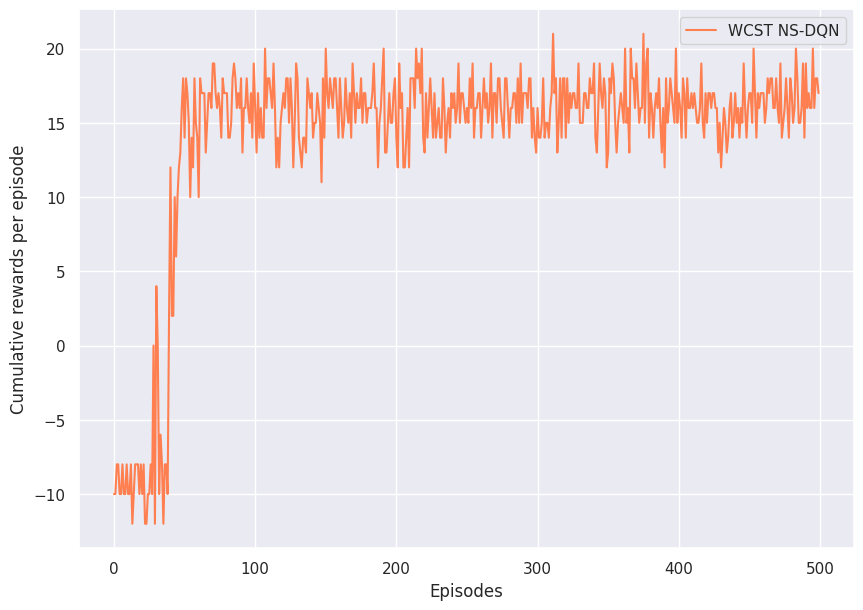

In [22]:
# Plotting the rewards over episodes
plt.figure(figsize=(10, 7))
plt.plot(episode_rewards_ns, label='WCST NS-DQN', color='coral')
plt.xlabel('Episodes')
plt.ylabel('Cumulative rewards per episode')
plt.grid(True)
plt.legend()
plt.show()

## End

## ALL 3 AGENTS PLOT

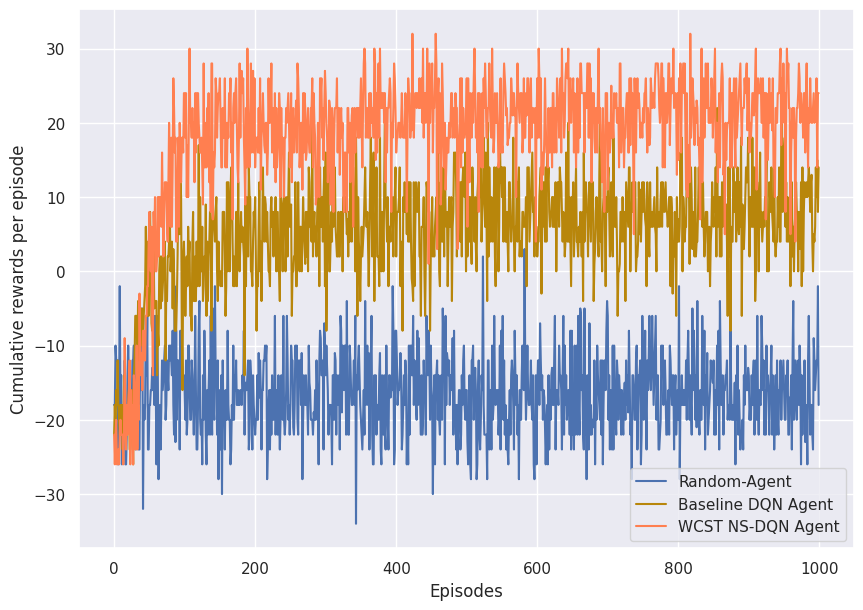

In [ ]:
# Plotting the rewards over episodes
plt.figure(figsize=(10, 7))
plt.plot(episode_rewards_r, label='Random-Agent')
plt.plot(episode_rewards, label='Baseline DQN Agent', color='darkgoldenrod')
plt.plot(episode_rewards_ns, label='WCST NS-DQN Agent', color='coral')
plt.xlabel('Episodes')
plt.ylabel('Cumulative rewards per episode')
plt.grid(True)
plt.legend()
plt.show()

## END PLOT